Notebook para comparar los modelos hechos del dataset ponderado (P2)

- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/46
- **Propósito del código:** Comparaciones de los modelos del dataframe de peleas ponderadas (P2).
- **Autor(es):** Carlos Vallejo.  
- **Descripción y uso:** El objetivo de este notebook es ver que modelo nos da el resultado más óptimo.

In [3]:
import os
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, f1_score, roc_auc_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import plot_tree


### Carga y preprocesamiento de los datos

Esta fase es global (excepto para xgboost con variables con diferencia)

In [4]:
ruta_train =  os.path.join("..","..","..", "data", "P2","train.parquet")
train = pd.read_parquet(ruta_train)

ruta_test =  os.path.join("..","..","..", "data", "P2","test.parquet")
test = pd.read_parquet(ruta_test)

np.random.seed(42)

test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Puntos_A,Puntos_B,Peleas_A,Peleas_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,0.00,0.40,0.4176,0.5208,0.2556,0.8640,...,86.483419,0.000000,7,13,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60
1,2022-11-19,Vince Morales,Miles Johns,True,0.24,0.64,0.4028,0.4848,0.1000,0.0000,...,69.390238,54.933053,7,5,-0.4,-0.0820,0.153846,0.00,0.36,-52.16
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.64,0.24,0.5220,0.4524,0.0000,0.2484,...,64.524204,127.265131,4,7,0.4,0.0696,-0.192661,0.00,0.00,-54.80
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.00,0.00,0.3240,0.4880,0.0900,0.2480,...,15.229011,37.550440,9,9,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.00,0.00,0.4532,0.5928,0.0432,0.2000,...,0.000000,58.874428,14,6,0.0,-0.1396,-0.158176,-1.68,0.40,189.72


## BASELINE

Como modelo base creamos un modelo que predice que gana el peleador que más ranking tenga (el peleador A).

In [5]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_baseline = train.drop(columns=columnasQuitar)
y_train_baseline = train['WINNER']
X_test_baseline = test.drop(columns=columnasQuitar)
y_test_baseline = test['WINNER']

y_pred_baseline = np.zeros_like(y_test_baseline)

print("Reporte de clasificación baseline:")
print(classification_report(y_test_baseline, y_pred_baseline, zero_division=0))


Reporte de clasificación baseline:
              precision    recall  f1-score   support

       False       0.55      1.00      0.71       349
        True       0.00      0.00      0.00       290

    accuracy                           0.55       639
   macro avg       0.27      0.50      0.35       639
weighted avg       0.30      0.55      0.39       639



-- Métricas del modelo base con hiperparámetros ajustados --
Accuracy: 0.5461658841940532
F1-Score: 0.0000
AUC-ROC: 0.5000
Precisión: 0.0000
Sensibilidad: 0.0000
Log-loss: 16.357839566266
[[349   0]
 [290   0]]


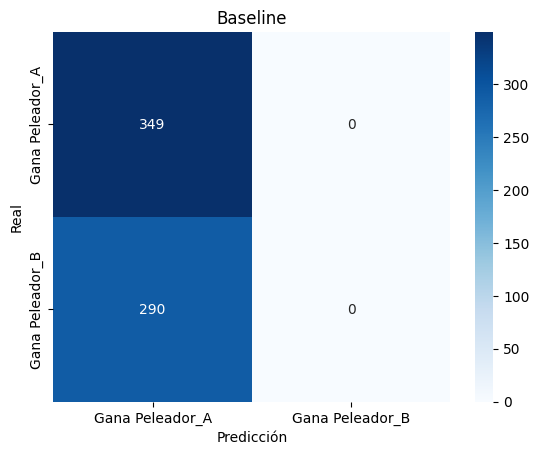

In [6]:
print("-- Métricas del modelo base con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_baseline, y_pred_baseline))
f1_test = f1_score(y_test_baseline, y_pred_baseline)
roc_auc_test = roc_auc_score(y_test_baseline, y_pred_baseline)
precision_test = precision_score(y_test_baseline, y_pred_baseline, zero_division=0)
recall_test = recall_score(y_test_baseline, y_pred_baseline, zero_division=0)
log_loss_test = log_loss(y_test_baseline,y_pred_baseline)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_baseline, y_pred_baseline))

cm = confusion_matrix(y_test_baseline, y_pred_baseline)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Baseline')
plt.show()

# Vamos a observar los mejores modelos antes de compararlos

## Árbol de decisión

Primero seleccionamos las variables a utilizar. En el caso del árbol escogemos todas excepto los nombres de los peleadores y la fecha de la pelea.

In [7]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_arbol = train.drop(columns=columnasQuitar)
y_train_arbol = train['WINNER']
X_test_arbol = test.drop(columns=columnasQuitar)
y_test_arbol = test['WINNER']

Ahora creamos el modelo teniendo en cuenta los hiperparámetros utilizados para crear el modelo más óptimo.

Reporte de clasificación árbol de decisión:
              precision    recall  f1-score   support

       False       0.62      0.39      0.48       349
        True       0.49      0.71      0.58       290

    accuracy                           0.53       639
   macro avg       0.55      0.55      0.53       639
weighted avg       0.56      0.53      0.52       639

Variables con importancia en el modelo: CTRL_A, Importancia: 0.20557
Variables con importancia en el modelo: STR_HEAD_B_x, Importancia: 0.42387
Variables con importancia en el modelo: Racha_A, Importancia: 0.37056


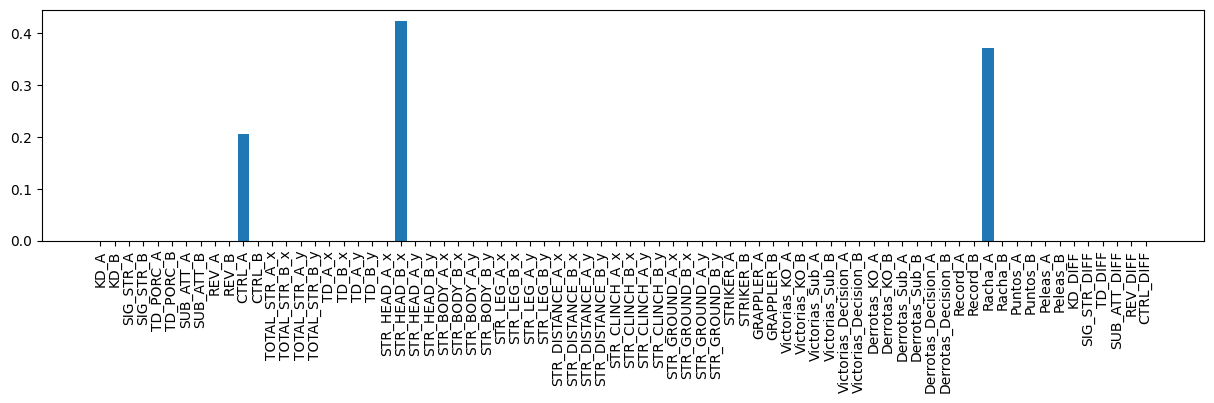

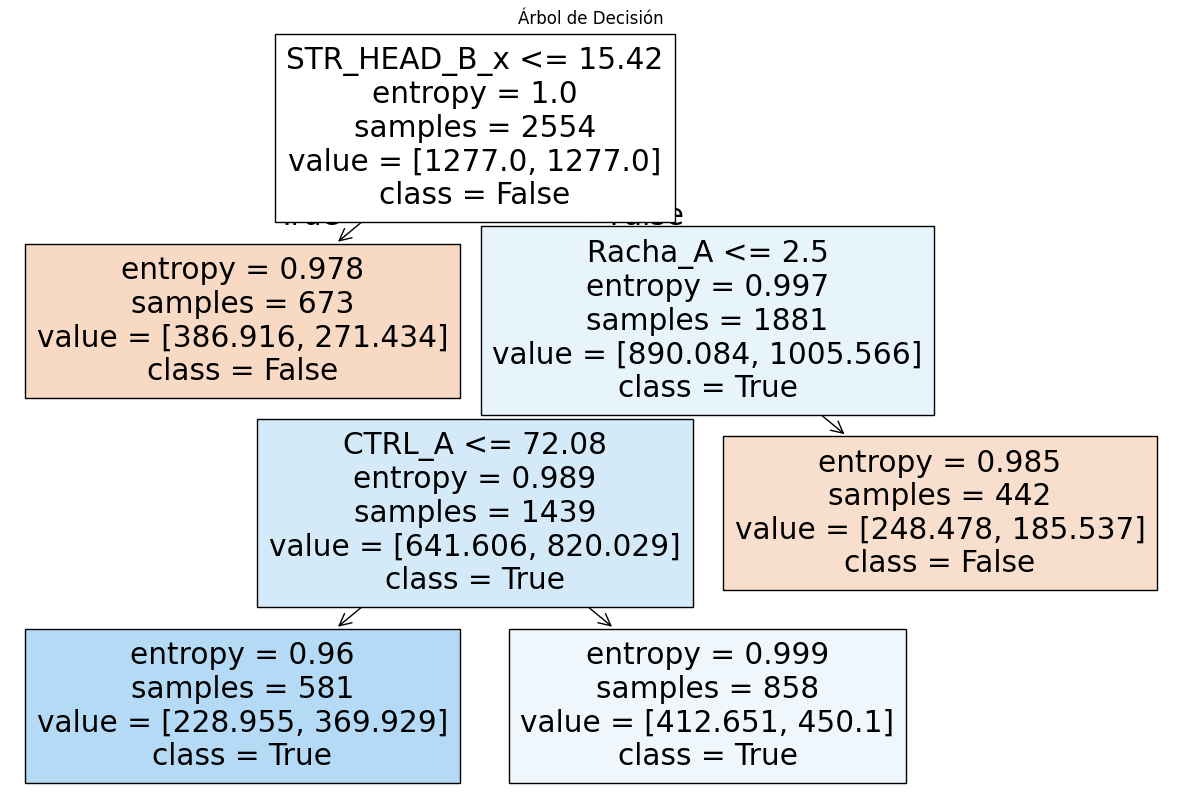

In [8]:
# Definir modelo base

arbol = DecisionTreeClassifier(
    criterion = 'entropy',  # Función para medir la calidad de la división
    max_depth = 3,  # Profundidad máxima del árbol
    min_samples_split = 2,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf = 13,  # Mínimo de muestras en una hoja
    min_weight_fraction_leaf = 0.14,
    splitter = 'best',
    class_weight = {np.False_: np.float64(0.8874218207088256), np.True_: np.float64(1.1452914798206277)},
    max_features = None,
	min_impurity_decrease = 0,
    random_state  =42    
)


# Entrenar el modelo
arbol.fit(X_train_arbol, y_train_arbol)

y_pred_arbol = arbol.predict(X_test_arbol)

print("Reporte de clasificación árbol de decisión:")
print(classification_report(y_test_arbol, y_pred_arbol))

importance = arbol.feature_importances_
feature_names=X_train_arbol.columns
for i,v in enumerate(importance):
	if v > 0:
	    print('Variables con importancia en el modelo: %s, Importancia: %.5f' % (feature_names[i],v))

#Visualización de las variables más importantes
plt.figure(figsize=(15, 3))
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 90)
plt.show()

#Visualización del árbol
plt.figure(figsize=(15, 10))
plot_tree(arbol, filled=True, feature_names=X_train_arbol.columns, class_names=[str(i) for i in np.unique(y_train_arbol)])
plt.title('Árbol de Decisión')
plt.show()


Viendo el modelo del árbol de decisión, observamos que hay dos variables que destacan por importancia sobre el resto, y que, no hay muchas variables con peso en el modelo. Esto resulta interesante para ver si estas variables tienen importancia parecida en los otros modelos. Ademas, como se puede ver en las métricas, este modelo es parecido al modelo base.

-- Métricas del árbol de decisión con hiperparámetros ajustados --
Accuracy: 0.5336463223787168
F1-Score: 0.5791
AUC-ROC: 0.5336
Precisión: 0.4904
Sensibilidad: 0.7069
Log-loss: 0.6988469578783765
[[136 213]
 [ 85 205]]


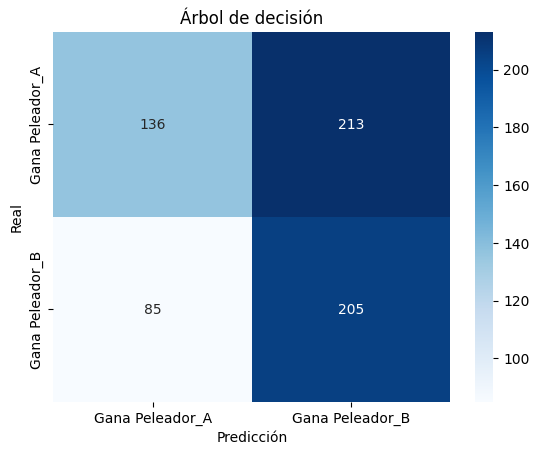

In [9]:
print("-- Métricas del árbol de decisión con hiperparámetros ajustados --")
y_prob_arbol = arbol.predict_proba(X_test_arbol)[:,1]
print("Accuracy:", accuracy_score(y_test_arbol, y_pred_arbol))
f1_test = f1_score(y_test_arbol, y_pred_arbol)
roc_auc_test = roc_auc_score(y_test_arbol, y_prob_arbol)
precision_test = precision_score(y_test_arbol, y_pred_arbol)
recall_test = recall_score(y_test_arbol, y_pred_arbol)
log_loss_test = log_loss(y_test_arbol,y_prob_arbol)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_arbol, y_pred_arbol))

cm = confusion_matrix(y_test_arbol, y_pred_arbol)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Árbol de decisión')
plt.show()

## XGboost

Las variables seleccionadas son las mismas que en el árbol de decisión.

In [10]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_xgboost = train.drop(columns=columnasQuitar)
y_train_xgboost = train['WINNER']
X_test_xgboost = test.drop(columns=columnasQuitar)
y_test_xgboost = test['WINNER']

Creamos el modelo teniendo en cuenta los mejores parámetros obtenidos en el notebook "XGBoost_pond.ipynb"

In [11]:
# Parámetros fijos
params = {
    'colsample_bytree': 0.5, 
    'gamma': 0.1, 
    'learning_rate': 0.05, 
    'min_child_weight': 35, 
    'n_estimators': 100, 
    'reg_alpha': 0.1, 
    'reg_lambda': 1.0, 
    'scale_pos_weight': np.float64(1.2905829596412555), 
    'subsample': 0.7
}



xgboost = XGBClassifier(**params,random_state=42)

xgboost.fit(X_train_xgboost, y_train_xgboost)

y_pred_xgboost = xgboost.predict(X_test_xgboost)

print("Reporte de clasificación xgboost:")
print(classification_report(y_test_xgboost, y_pred_xgboost))
print(f'Accuracy: {accuracy_score(y_test_xgboost, y_pred_xgboost):.4f}')
print(f"F1-score: {f1_score(y_test_xgboost,y_pred_xgboost)}")

Reporte de clasificación xgboost:
              precision    recall  f1-score   support

       False       0.64      0.62      0.63       349
        True       0.56      0.57      0.56       290

    accuracy                           0.60       639
   macro avg       0.60      0.60      0.60       639
weighted avg       0.60      0.60      0.60       639

Accuracy: 0.5994
F1-score: 0.564625850340136


-- Métricas del modelo de xgboost con hiperparámetros ajustados --
Accuracy: 0.5993740219092332
F1-Score: 0.5646
AUC-ROC: 0.6119
Precisión: 0.5570
Sensibilidad: 0.5724
Log-loss: 0.6760151368618069
[[217 132]
 [124 166]]


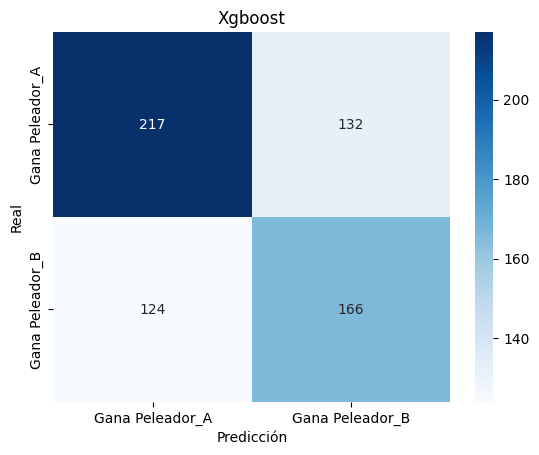

In [12]:
print("-- Métricas del modelo de xgboost con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_xgboost, y_pred_xgboost))
y_prob_xgboost = xgboost.predict_proba(X_test_xgboost)[:,1]
f1_test = f1_score(y_test_xgboost, y_pred_xgboost)
roc_auc_test = roc_auc_score(y_test_xgboost, y_prob_xgboost)
precision_test = precision_score(y_test_xgboost, y_pred_xgboost)
recall_test = recall_score(y_test_xgboost, y_pred_xgboost)
log_loss_test = log_loss(y_test_xgboost,y_prob_xgboost)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_xgboost, y_pred_xgboost))

cm = confusion_matrix(y_test_xgboost, y_pred_xgboost)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Xgboost')
plt.show()

## Xgboost con variables como diferencia

In [13]:
ruta_train_dif =  os.path.join("..","..","..", "data", "P2_dif","train.parquet")
train_dif = pd.read_parquet(ruta_train_dif)

ruta_test_dif =  os.path.join("..","..","..", "data", "P2_dif","test.parquet")
test_dif = pd.read_parquet(ruta_test_dif)

test_dif.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2022-11-19,Kennedy Nzechukwu,Ion Cutelaba,False,-0.4,-0.1032,-0.110729,0.36,0.00,-39.60,...,-1.0,-6,86.483419,1,-0.64,0.00,-1.0,-1.00,-1.96,-1.40
1,2022-11-19,Vince Morales,Miles Johns,True,-0.4,-0.0820,0.153846,0.00,0.36,-52.16,...,0.0,2,14.457185,0,-1.00,0.00,1.0,0.00,-0.36,2.36
2,2022-11-19,Andre Fialho,Muslim Salikhov,True,0.4,0.0696,-0.192661,0.00,0.00,-54.80,...,-4.0,-3,-62.740928,0,-0.40,0.00,-2.6,0.00,-1.00,1.00
3,2022-11-19,Jennifer Maia,Maryna Moroz,False,0.0,-0.1640,-0.069020,-1.08,0.00,-340.04,...,2.0,0,-22.321428,-3,0.00,-0.36,-0.6,0.00,0.00,0.96
4,2022-12-03,Eryk Anders,Kyle Daukaus,False,0.0,-0.1396,-0.158176,-1.68,0.40,189.72,...,-1.0,8,-58.874428,0,3.00,-0.60,2.0,0.64,0.60,2.36


In [14]:
columnasQuitar = ["DATE","Peleador_A","Peleador_B", "WINNER"]

X_train_xgboost_dif = train_dif.drop(columns=columnasQuitar)
y_train_xgboost_dif = train_dif['WINNER']
X_test_xgboost_dif = test_dif.drop(columns=columnasQuitar)
y_test_xgboost_dif = test_dif['WINNER']

In [15]:
# Parámetros fijos
params = {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.013855267540212752, 'subsample': 0.7097002483532678, 'colsample_bytree': 0.9049166524337446, 'gamma': 0.3376761198544125, 'min_child_weight': 13, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'} 

xgboost_dif = XGBClassifier(**params)

xgboost_dif.fit(X_train_xgboost_dif, y_train_xgboost_dif)

y_pred_xgboost_dif = xgboost_dif.predict(X_test_xgboost_dif)

print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test_xgboost_dif, y_pred_xgboost_dif))
print(f'Accuracy: {accuracy_score(y_test_xgboost_dif, y_pred_xgboost_dif):.4f}')
print(f"F1-score: {f1_score(y_test_xgboost_dif,y_pred_xgboost_dif)}")

Reporte de clasificación xgboost_dif:
              precision    recall  f1-score   support

       False       0.64      0.64      0.64       349
        True       0.56      0.56      0.56       290

    accuracy                           0.60       639
   macro avg       0.60      0.60      0.60       639
weighted avg       0.60      0.60      0.60       639

Accuracy: 0.6025
F1-score: 0.5605536332179931


-- Métricas del modelo de xgboost_dif con hiperparámetros ajustados --
Accuracy: 0.6025039123630673
F1-Score: 0.5606
AUC-ROC: 0.6118
Precisión: 0.5625
Sensibilidad: 0.5586
Log-loss: 0.6739841810064041
[[223 126]
 [128 162]]


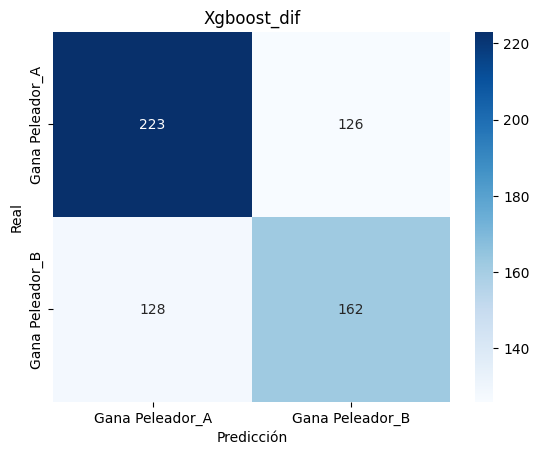

In [16]:
print("-- Métricas del modelo de xgboost_dif con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_xgboost_dif, y_pred_xgboost_dif))
y_prob_xgboost_dif = xgboost_dif.predict_proba(X_test_xgboost_dif)[:,1]
f1_test = f1_score(y_test_xgboost_dif, y_pred_xgboost_dif)
roc_auc_test = roc_auc_score(y_test_xgboost_dif, y_prob_xgboost_dif)
precision_test = precision_score(y_test_xgboost_dif, y_pred_xgboost_dif)
recall_test = recall_score(y_test_xgboost_dif, y_pred_xgboost_dif)
log_loss_test = log_loss(y_test_xgboost_dif,y_prob_xgboost_dif)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_xgboost_dif, y_pred_xgboost_dif))

cm = confusion_matrix(y_test_xgboost_dif, y_pred_xgboost_dif)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Xgboost_dif')
plt.show()

## Regresión logística

En regresión logística sí eliminamos variables (para ver el proceso, está en "regresion_logistica_P2_Fran.ipynb").

In [17]:
X_train_rl = train[['TD_PORC_B', 'CTRL_A', 'CTRL_B', 'TOTAL_STR_B_x', 'TD_B_y', 'STR_BODY_A_y', 'STR_BODY_B_y', 'STR_LEG_A_y', 'Derrotas_KO_A', 'Derrotas_Sub_A', 'Derrotas_Decision_A', 'Record_A', 'Racha_A', 'Racha_B', 'Puntos_A', 'Puntos_B', 'Peleas_A', 'Peleas_B', 'REV_DIFF']]
y_train_rl = train['WINNER']
X_test_rl = test[['TD_PORC_B', 'CTRL_A', 'CTRL_B', 'TOTAL_STR_B_x', 'TD_B_y', 'STR_BODY_A_y', 'STR_BODY_B_y', 'STR_LEG_A_y', 'Derrotas_KO_A', 'Derrotas_Sub_A', 'Derrotas_Decision_A', 'Record_A', 'Racha_A', 'Racha_B', 'Puntos_A', 'Puntos_B', 'Peleas_A', 'Peleas_B', 'REV_DIFF']]
y_test_rl = test['WINNER']

scaler = RobustScaler()
X_train_rl = scaler.fit_transform(X_train_rl)
X_test_rl = scaler.transform(X_test_rl)

In [18]:


model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Aumentamos las iteraciones para asegurar convergencia
    solver='saga',  # 'saga' soporta L1 y L2
    C=1,  # Valor específico para C
    penalty='elasticnet',  # Usamos L1 como penalización
    class_weight = 'balanced',
    l1_ratio = 1.0
)

# Pipeline sin características polinomiales si no es necesario
rl = make_pipeline(
    model
)

# Ajustar el modelo con los datos de entrenamiento
rl.fit(X_train_rl, y_train_rl)

y_pred_rl = rl.predict(X_test_rl)

print("Reporte de clasificación regresión logística:")
print(classification_report(y_test_rl, y_pred_rl)) 


Reporte de clasificación regresión logística:
              precision    recall  f1-score   support

       False       0.65      0.52      0.57       349
        True       0.53      0.66      0.59       290

    accuracy                           0.58       639
   macro avg       0.59      0.59      0.58       639
weighted avg       0.59      0.58      0.58       639



-- Métricas del modelo de regresión logística con hiperparámetros ajustados --
Accuracy: 0.5805946791862285
F1-Score: 0.5877
AUC-ROC: 0.6269
Precisión: 0.5306
Sensibilidad: 0.6586
Log-loss: 0.6735903894931992
[[180 169]
 [ 99 191]]


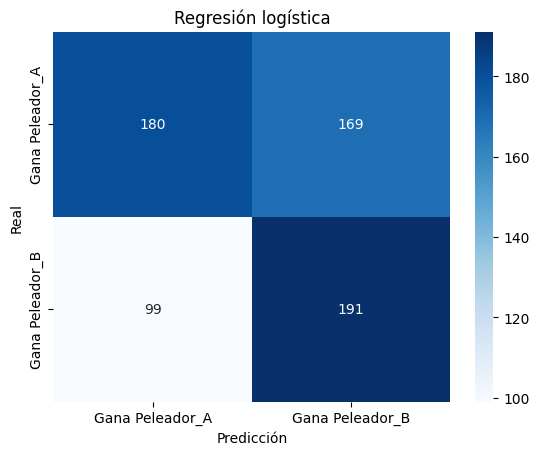

In [19]:
print("-- Métricas del modelo de regresión logística con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_rl, y_pred_rl))
y_prob_rl = rl.predict_proba(X_test_rl)[:,1]
f1_test = f1_score(y_test_rl, y_pred_rl)
roc_auc_test = roc_auc_score(y_test_rl, y_prob_rl)
precision_test = precision_score(y_test_rl, y_pred_rl)
recall_test = recall_score(y_test_rl, y_pred_rl)
log_loss_test = log_loss(y_test_rl,y_prob_rl)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_rl, y_pred_rl))

cm = confusion_matrix(y_test_rl, y_pred_rl)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Regresión logística')
plt.show()

## COMPARACIÓN

En esta parte vamos a comparar los modelos de arriba.

In [20]:

print("Reporte de clasificación baseline:")
print(classification_report(y_test_baseline, y_pred_baseline, zero_division=0))
print("Reporte de clasificación baseline:")
print(classification_report(y_test_baseline, y_pred_baseline, zero_division=0))
print("Reporte de clasificación árbol de decisión:")
print(classification_report(y_test_arbol, y_pred_arbol, zero_division=0))
print("Reporte de clasificación xgboost:")
print(classification_report(y_test_xgboost, y_pred_xgboost, zero_division=0))
print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test_xgboost_dif, y_pred_xgboost_dif, zero_division=0))
print("Reporte de clasificación regresión logística:")
print(classification_report(y_test_rl, y_pred_rl, zero_division=0)) 

Reporte de clasificación baseline:
              precision    recall  f1-score   support

       False       0.55      1.00      0.71       349
        True       0.00      0.00      0.00       290

    accuracy                           0.55       639
   macro avg       0.27      0.50      0.35       639
weighted avg       0.30      0.55      0.39       639

Reporte de clasificación baseline:
              precision    recall  f1-score   support

       False       0.55      1.00      0.71       349
        True       0.00      0.00      0.00       290

    accuracy                           0.55       639
   macro avg       0.27      0.50      0.35       639
weighted avg       0.30      0.55      0.39       639

Reporte de clasificación árbol de decisión:
              precision    recall  f1-score   support

       False       0.62      0.39      0.48       349
        True       0.49      0.71      0.58       290

    accuracy                           0.53       639
   macro avg  

In [21]:
print("-- Métricas del modelo base con hiperparámetros ajustados --")
print("Accuracy:", accuracy_score(y_test_baseline, y_pred_baseline))
f1_test = f1_score(y_test_baseline, y_pred_baseline)
roc_auc_test = roc_auc_score(y_test_baseline, y_pred_baseline)
precision_test = precision_score(y_test_baseline, y_pred_baseline, zero_division=0)
recall_test = recall_score(y_test_baseline, y_pred_baseline, zero_division=0)
log_loss_test = log_loss(y_test_baseline,y_test_baseline)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_baseline, y_pred_baseline))

print("--------------------------")

print("-- Métricas del árbol de decisión con hiperparámetros ajustados --")
y_prob_arbol = arbol.predict_proba(X_test_arbol)[:,1]
print("Accuracy:", accuracy_score(y_test_arbol, y_pred_arbol))
f1_test = f1_score(y_test_arbol, y_pred_arbol)
roc_auc_test = roc_auc_score(y_test_arbol, y_prob_arbol)
precision_test = precision_score(y_test_arbol, y_pred_arbol)
recall_test = recall_score(y_test_arbol, y_pred_arbol)
log_loss_test = log_loss(y_test_arbol,y_prob_arbol)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")

print("--------------------------")

print("-- Métricas del modelo de xgboost con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_xgboost, y_pred_xgboost))
y_prob_xgboost = xgboost.predict_proba(X_test_xgboost)[:,1]
f1_test = f1_score(y_test_xgboost, y_pred_xgboost)
roc_auc_test = roc_auc_score(y_test_xgboost, y_prob_xgboost)
precision_test = precision_score(y_test_xgboost, y_pred_xgboost)
recall_test = recall_score(y_test_xgboost, y_pred_xgboost)
log_loss_test = log_loss(y_test_xgboost,y_prob_xgboost)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")

print("--------------------------")

print("-- Métricas del modelo de xgboost_dif con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_xgboost_dif, y_pred_xgboost_dif))
y_prob_xgboost_dif = xgboost_dif.predict_proba(X_test_xgboost_dif)[:,1]
f1_test = f1_score(y_test_xgboost_dif, y_pred_xgboost_dif)
roc_auc_test = roc_auc_score(y_test_xgboost_dif, y_prob_xgboost_dif)
precision_test = precision_score(y_test_xgboost_dif, y_pred_xgboost_dif)
recall_test = recall_score(y_test_xgboost_dif, y_pred_xgboost_dif)
log_loss_test = log_loss(y_test_xgboost_dif,y_prob_xgboost_dif)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")
print(confusion_matrix(y_test_xgboost_dif, y_pred_xgboost_dif))

print("--------------------------")

print("-- Métricas del modelo de regresión logística con hiperparámetros ajustados --")

print("Accuracy:", accuracy_score(y_test_rl, y_pred_rl))
y_prob_rl = rl.predict_proba(X_test_rl)[:,1]
f1_test = f1_score(y_test_rl, y_pred_rl)
roc_auc_test = roc_auc_score(y_test_rl, y_prob_rl)
precision_test = precision_score(y_test_rl, y_pred_rl)
recall_test = recall_score(y_test_rl, y_pred_rl)
log_loss_test = log_loss(y_test_rl,y_prob_rl)
print(f"F1-Score: {f1_test:.4f}")
print(f"AUC-ROC: {roc_auc_test:.4f}")
print(f"Precisión: {precision_test:.4f}")
print(f"Sensibilidad: {recall_test:.4f}")
print(f"Log-loss: {log_loss_test}")

-- Métricas del modelo base con hiperparámetros ajustados --
Accuracy: 0.5461658841940532
F1-Score: 0.0000
AUC-ROC: 0.5000
Precisión: 0.0000
Sensibilidad: 0.0000
Log-loss: 2.220446049250313e-16
[[349   0]
 [290   0]]
--------------------------
-- Métricas del árbol de decisión con hiperparámetros ajustados --
Accuracy: 0.5336463223787168
F1-Score: 0.5791
AUC-ROC: 0.5336
Precisión: 0.4904
Sensibilidad: 0.7069
Log-loss: 0.6988469578783765
--------------------------
-- Métricas del modelo de xgboost con hiperparámetros ajustados --
Accuracy: 0.5993740219092332
F1-Score: 0.5646
AUC-ROC: 0.6119
Precisión: 0.5570
Sensibilidad: 0.5724
Log-loss: 0.6760151368618069
--------------------------
-- Métricas del modelo de xgboost_dif con hiperparámetros ajustados --
Accuracy: 0.6025039123630673
F1-Score: 0.5606
AUC-ROC: 0.6118
Precisión: 0.5625
Sensibilidad: 0.5586
Log-loss: 0.6739841810064041
[[223 126]
 [128 162]]
--------------------------
-- Métricas del modelo de regresión logística con hiperpa

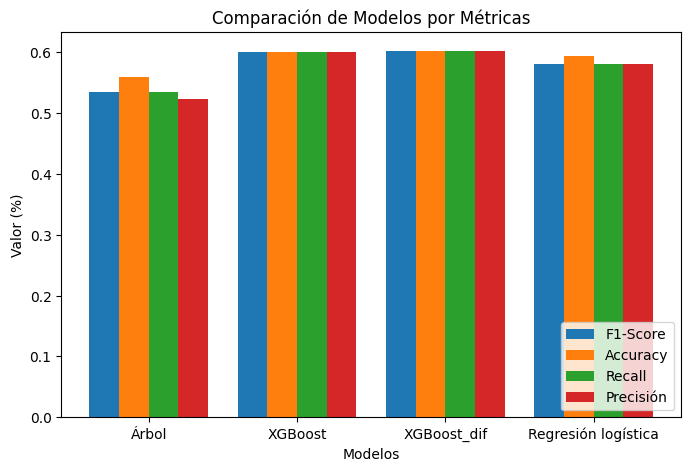

In [33]:
def evaluate_model(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1-score': f1_score(y_true, y_pred, average='weighted')
    }
results = [
    evaluate_model(y_test_arbol, y_pred_arbol, arbol),
    evaluate_model(y_test_xgboost, y_pred_xgboost, xgboost),
    evaluate_model(y_test_xgboost_dif, y_pred_xgboost_dif, xgboost_dif),
    evaluate_model(y_test_rl, y_pred_rl, rl)
]
df_results = pd.DataFrame(results)

modelos = ["Árbol", "XGBoost", "XGBoost_dif", "Regresión logística"]
metricas = ["F1-Score", "Accuracy", "Recall", "Precisión"]

valores = np.array([
    df_results.iloc[0][['Accuracy', 'Precision', 'Recall', 'F1-score']].values,
    df_results.iloc[1][['Accuracy', 'Precision', 'Recall', 'F1-score']].values,
    df_results.iloc[2][['Accuracy', 'Precision', 'Recall', 'F1-score']].values,
    df_results.iloc[3][['Accuracy', 'Precision', 'Recall', 'F1-score']].values
])

x = np.arange(len(modelos))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(metricas)):
    ax.bar(x + i * width - width * 1.5, valores[:, i], width, label=metricas[i])

ax.set_xlabel("Modelos")
ax.set_ylabel("Valor (%)")
ax.set_title("Comparación de Modelos por Métricas")
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend(loc = 'lower right')

plt.show()

Como se puede observar en la gráfica, el modelo del árbol de decisión es el que obtiene peores resultados, seguido de la regresión logística. Los dos mejores modelos son los realizados con XGBoost que sus resultados apenas se diferencian.

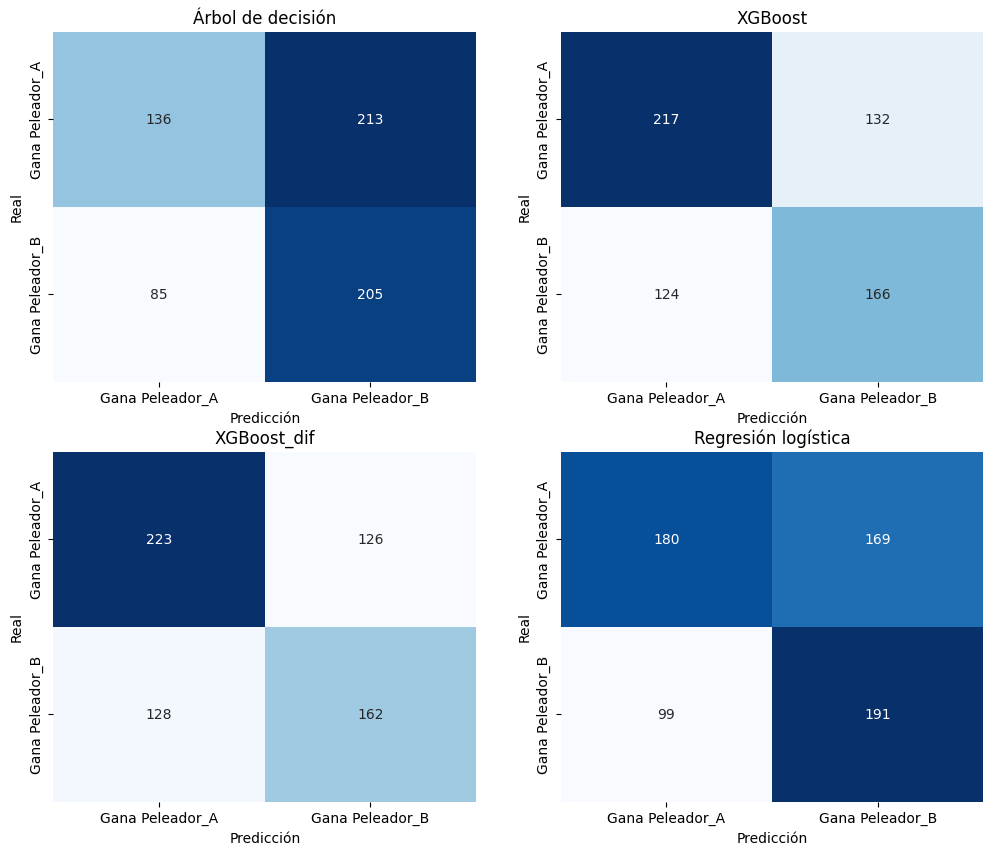

In [23]:
# Configurar el tamaño de la figura
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 filas, 2 columnas

# Definir títulos y datos de los modelos
titulos = ["Árbol de decisión", "XGBoost", "XGBoost_dif", "Regresión logística"]
y_tests = [y_test_arbol, y_test_xgboost, y_test_xgboost_dif, y_test_rl]
y_preds = [y_pred_arbol, y_pred_xgboost, y_pred_xgboost_dif, y_pred_rl]

# Generar las matrices de confusión en los subgráficos
for ax, title, y_test, y_pred in zip(axes.flat, titulos, y_tests, y_preds):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], 
                yticklabels=['Gana Peleador_A', 'Gana Peleador_B'], ax=ax, cbar = False)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_title(title)
    
plt.show()

## Análisis de los datos

Cogemos los datos del modelo de XGBoost_dif ya que es el que mejor predice.

In [24]:
columnas_extra = ["DATE", "Peleador_A", "Peleador_B", "WINNER"]

resultados = X_test_xgboost_dif.copy()
resultados[columnas_extra] = test_dif[columnas_extra]
resultados["Predicho"] = y_pred_xgboost_dif
resultados["Correcto"] = resultados["WINNER"] == resultados["Predicho"]
# En el dataframe resultados tengo todas las variables además de dos nuevas, la predicción del ganador y si ha acertado o no

luchas = test_dif[columnas_extra].copy()
luchas["Predicho"] = y_pred_xgboost_dif
# En el dataframe luchas solo tengo la fecha, el nombre de los peleadores, quien ha ganado y que ha predecido el modelo

print("Resultados:")
print(resultados.head())

print("\nLuchas:")
print(luchas.head())

Resultados:
   KD_DIFF  SIG_STR_DIFF   TD_DIFF  SUB_ATT_DIFF  REV_DIFF  CTRL_DIFF  \
0     -0.4       -0.1032 -0.110729          0.36      0.00     -39.60   
1     -0.4       -0.0820  0.153846          0.00      0.36     -52.16   
2      0.4        0.0696 -0.192661          0.00      0.00     -54.80   
3      0.0       -0.1640 -0.069020         -1.08      0.00    -340.04   
4      0.0       -0.1396 -0.158176         -1.68      0.40     189.72   

   TD_PORC_DIFF  TOTAL_STR_A_DIFF  TD_A_DIFF  STR_HEAD_A_DIFF  ...  \
0       -0.6084             28.68      -3.36            21.64  ...   
1        0.1000             48.12      -1.56            28.12  ...   
2       -0.2484            -43.40      -3.36           -26.24  ...   
3       -0.1580             20.20      -5.40            53.92  ...   
4       -0.1568             97.56       7.04            59.44  ...   

   Victorias_Decision_DIFF  Derrotas_KO_DIFF  Derrotas_Sub_DIFF  \
0                     -1.0             -1.00              -1.

Ahora divido el dataframe entre las muestras que se aciertan y las que no

In [25]:
aciertos = resultados[resultados["Correcto"] == True]
fallos = resultados[resultados["Correcto"] == False]
#En aciertos están las muestras que el modelo ha acertado y en fallos las muestras en las que ha fallado

# Mostrar los primeros registros de cada DataFrame
print("Aciertos:")
print(aciertos.head())

print("\nErrores:")
print(fallos.head())

Aciertos:
   KD_DIFF  SIG_STR_DIFF   TD_DIFF  SUB_ATT_DIFF  REV_DIFF  CTRL_DIFF  \
0     -0.4       -0.1032 -0.110729          0.36      0.00     -39.60   
1     -0.4       -0.0820  0.153846          0.00      0.36     -52.16   
2      0.4        0.0696 -0.192661          0.00      0.00     -54.80   
4      0.0       -0.1396 -0.158176         -1.68      0.40     189.72   
6     -0.6        0.0120 -0.113672          0.24     -0.80      14.44   

   TD_PORC_DIFF  TOTAL_STR_A_DIFF  TD_A_DIFF  STR_HEAD_A_DIFF  ...  \
0       -0.6084             28.68      -3.36            21.64  ...   
1        0.1000             48.12      -1.56            28.12  ...   
2       -0.2484            -43.40      -3.36           -26.24  ...   
4       -0.1568             97.56       7.04            59.44  ...   
6       -0.0132            179.52      -0.44           100.28  ...   

   Victorias_Decision_DIFF  Derrotas_KO_DIFF  Derrotas_Sub_DIFF  \
0                    -1.00             -1.00              -1.96

### TENDENCIAS

C:\Users\Equipo\AppData\Local\Temp\ipykernel_24020\2447407722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fallos["DATE"] = pd.to_datetime(fallos["DATE"])


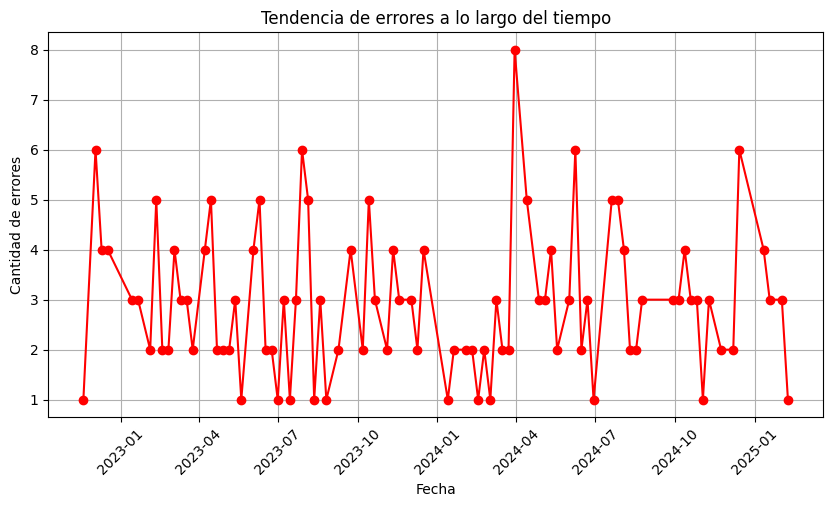

In [ ]:
#Asegurar que la columna DATE es de tipo datetime
fallos["DATE"] = pd.to_datetime(fallos["DATE"])

# Agrupar por fecha y contar los errores
errores_por_fecha = fallos.groupby("DATE").size()

# Graficar la tendencia de errores a lo largo del tiempo
plt.figure(figsize=(10, 5))
plt.plot(errores_por_fecha.index, errores_por_fecha.values, marker='o', linestyle='-', color='red')

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Cantidad de errores")
plt.title("Tendencia de errores a lo largo del tiempo")
plt.xticks(rotation=45)  # Rotar las fechas para mejor visibilidad
plt.grid(True)
plt.show()

C:\Users\Equipo\AppData\Local\Temp\ipykernel_24020\2264359729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aciertos["DATE"] = pd.to_datetime(aciertos["DATE"])


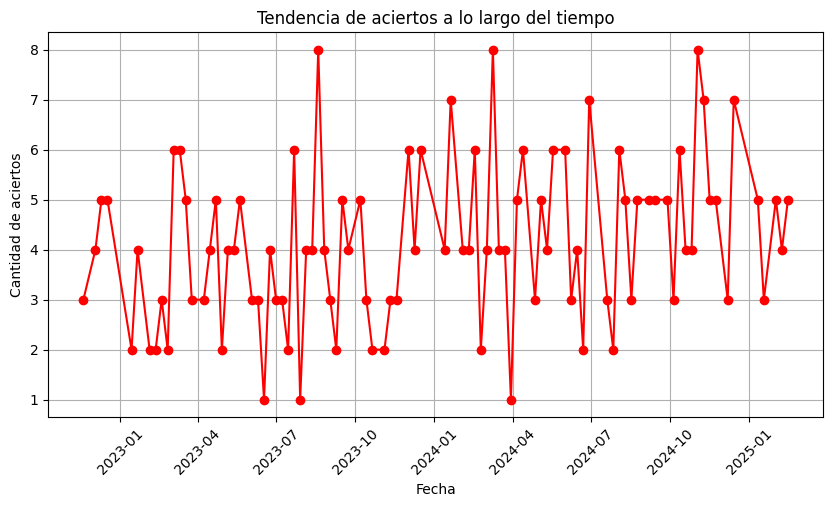

In [ ]:
#Asegurar que la columna DATE es de tipo datetime
aciertos["DATE"] = pd.to_datetime(aciertos["DATE"])

# Agrupar por fecha y contar los errores
aciertos_por_fecha = aciertos.groupby("DATE").size()

# Graficar la tendencia de errores a lo largo del tiempo
plt.figure(figsize=(10, 5))
plt.plot(aciertos_por_fecha.index, aciertos_por_fecha.values, marker='o', linestyle='-', color='red')

# Etiquetas y título
plt.xlabel("Fecha")
plt.ylabel("Cantidad de aciertos")
plt.title("Tendencia de aciertos a lo largo del tiempo")
plt.xticks(rotation=45)  # Rotar las fechas para mejor visibilidad
plt.grid(True)
plt.show()

Al observar la gráfica, no se identifica una tendencia clara en el número de errores a lo largo del tiempo. Esto es una señal positiva, ya que indicaría que el desempeño del modelo no se ha deteriorado con el tiempo.

Además, desde julio de 2024, no se han registrado eventos con menos de 3 aciertos, lo que sugiere una posible mejora en la precisión del modelo en fechas recientes. Si bien esta última observación no permite sacar una conclusión definitiva, es un indicio favorable que refuerza la idea de un mejor desempeño en los eventos más recientes.

In [ ]:
num_bins = 10

# Obtener los límites de los bins a partir del conjunto completo
min_val = min(fallos["Racha_DIFF"].min(), aciertos["Racha_DIFF"].min())
max_val = max(fallos["Racha_DIFF"].max(), aciertos["Racha_DIFF"].max())

# Crear los bins globales
bins = np.linspace(min_val, max_val, num_bins + 1)

# Asignar los intervalos usando los mismos bins en ambos DataFrames
fallos.loc[:, "Intervalo"] = pd.cut(fallos["Racha_DIFF"], bins=bins, include_lowest=True)
aciertos.loc[:, "Intervalo"] = pd.cut(aciertos["Racha_DIFF"], bins=bins, include_lowest=True)

# Contar la cantidad de errores y aciertos en cada intervalo
errores_por_intervalo = errores["Intervalo"].value_counts().sort_index()
aciertos_por_intervalo = aciertos["Intervalo"].value_counts().sort_index()

# Crear posiciones en el eje X
x = np.arange(len(errores_por_intervalo))

# Ancho de las barras
width = 0.4  

# Crear el gráfico
plt.figure(figsize=(12, 5))

# Barras de errores (rojo, desplazadas a la izquierda)
plt.bar(x - width/2, errores_por_intervalo.values, width=width, color='red', label="Errores")

# Barras de aciertos (azul, desplazadas a la derecha)
plt.bar(x + width/2, aciertos_por_intervalo.values, width=width, color='blue', label="Aciertos")

# Configurar etiquetas del eje X con los intervalos
plt.xticks(x, errores_por_intervalo.index.astype(str), rotation=45)

# Etiquetas y título
plt.xlabel("Intervalos de Racha_DIFF")
plt.ylabel("Cantidad")
plt.title("Distribución de errores y aciertos según Racha_DIFF")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

C:\Users\Equipo\AppData\Local\Temp\ipykernel_24020\2058139553.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fallos.loc[:, "Intervalo"] = pd.cut(fallos["Racha_DIFF"], bins=bins, include_lowest=True)
C:\Users\Equipo\AppData\Local\Temp\ipykernel_24020\2058139553.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aciertos.loc[:, "Intervalo"] = pd.cut(aciertos["Racha_DIFF"], bins=bins, include_lowest=True)


KeyError: 'Intervalo'

Viendo la gráfica, observamos que el modelo obtiene mejores resultados cuando el peleador A tiene una racha superior a la del peleador B. Sin embargo, cuando ocurre lo contrario, el modelo presenta mayores dificultades. A medida que el valor de Racha_DIFF se vuelve más negativo, el porcentaje de errores y aciertos se equilibra, e incluso en el último intervalo los errores superan a los aciertos.

Un aspecto positivo es que, incluso cuando los peleadores tienen rachas similares, el modelo sigue logrando un mayor número de aciertos que de errores. Esto indica que es capaz de realizar predicciones precisas en combates equilibrados y no solo en enfrentamientos claramente desbalanceados.

